In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(1)
n_samples = 3000
filter_order = 3 # 16 coeficientes
n_coeffs = filter_order + 1

# Entrada e Planta
x = (np.random.randn(n_samples) + 1j*np.random.randn(n_samples)) / np.sqrt(2)
w_true = np.random.randn(n_coeffs) + 1j*np.random.randn(n_coeffs)

# Sinal desejado com ruído
noise_std = 0.05
d_clean = np.zeros(n_samples, dtype=complex)
for k in range(n_coeffs, n_samples):
    d_clean[k] = np.vdot(w_true, x[k:k-n_coeffs:-1])
d = d_clean + noise_std * (np.random.randn(n_samples) + 1j*np.random.randn(n_samples))

# --- 2. DEFINIÇÃO DO SELECTOR (Partial Update) ---
# Vamos atualizar apenas 4 dos 16 coeficientes a cada iteração (25% de carga)
# Usaremos um esquema de Round-Robin simples
up_selector = np.zeros((n_coeffs, n_samples))
for k in range(n_samples):
    # Seleciona 4 índices rotativos
    indices = np.arange(k*4, (k+1)*4) % n_coeffs
    up_selector[indices, k] = 1

# --- 3. EXECUÇÃO DO FILTRO ---
filt_puap = pdf.SimplifiedSMPUAP(
    filter_order=filter_order,
    gamma_bar=0.01, # Threshold de erro
    gamma=0.9,    # Regularização (importante para estabilidade no PU)
    L=2,           # Ordem de projeção (reuso de dados)
    up_selector=up_selector
)

result = filt_puap.optimize(x, d, verbose=True, return_internal_states=True)

[SM-Simp-PUAP] Updates: 2961/3000 | Runtime: 50.04 ms


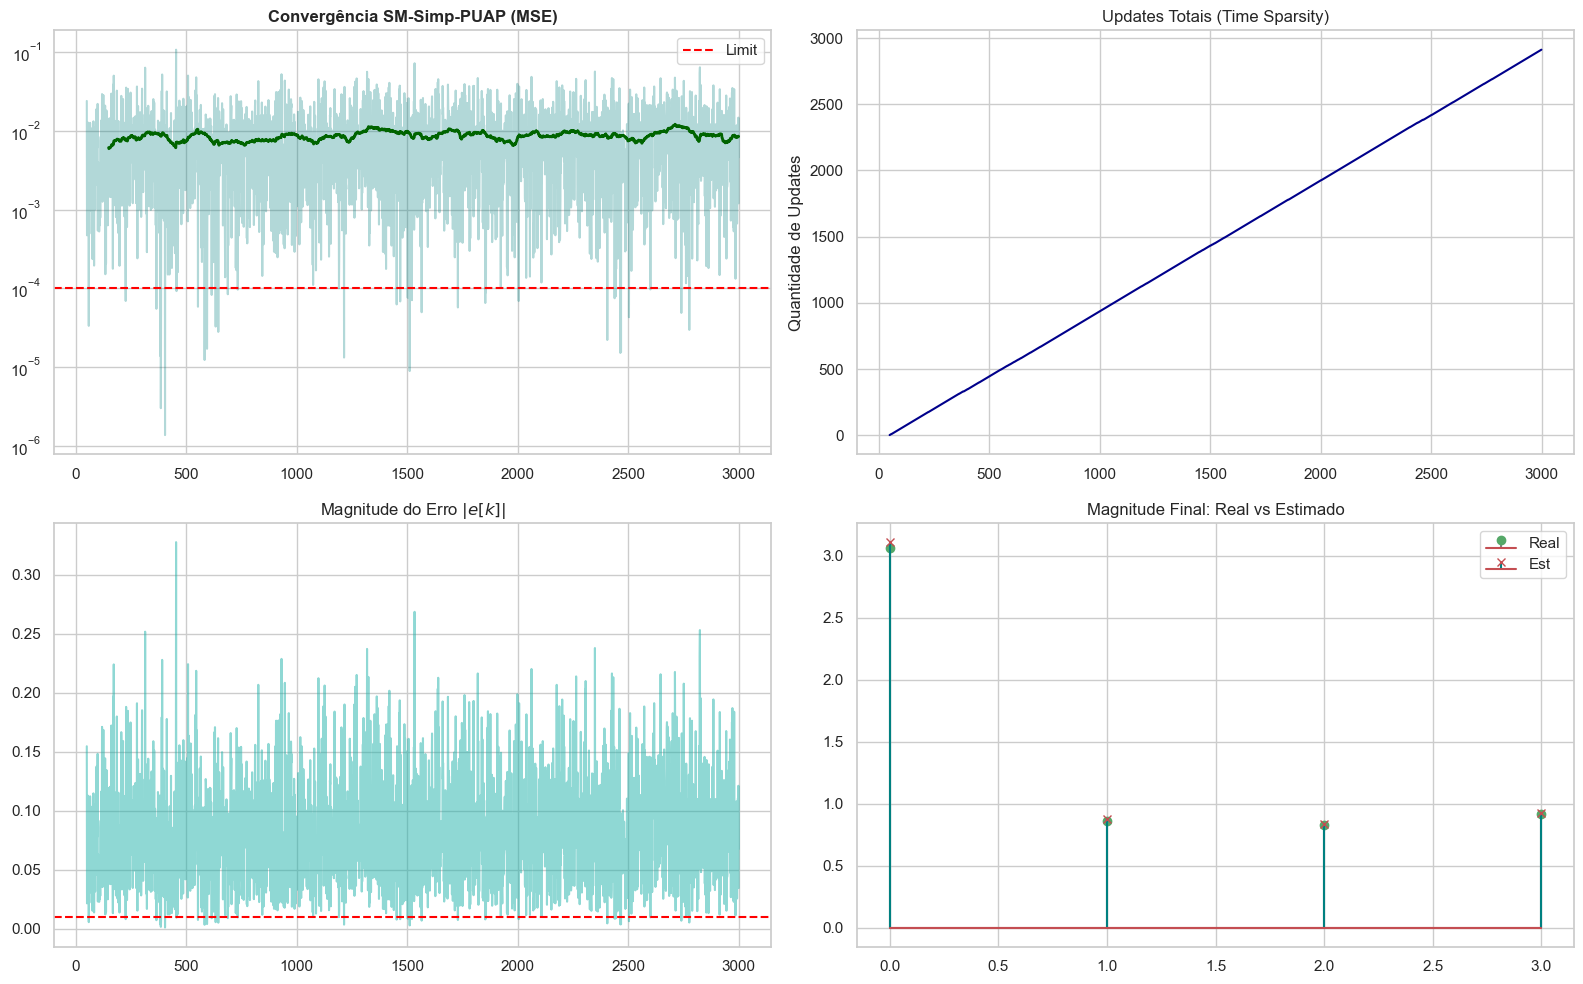

In [3]:
# --- 4. DASHBOARD DE DIAGNÓSTICO ---
def plot_puap_dashboard(result, w_true, g_bar, offset=50):
    sns.set_theme(style="whitegrid")
    t = np.arange(len(result.mse()))[offset:]
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2)

    # A. MSE Convergência
    ax1 = fig.add_subplot(gs[0, 0])
    mse = result.mse()[offset:]
    ax1.semilogy(t, mse, color='teal', alpha=0.3)
    ax1.semilogy(t, pd.Series(mse).rolling(100).mean(), color='darkgreen', lw=2)
    ax1.axhline(y=g_bar**2, color='red', ls='--', label='Limit')
    ax1.set_title("Convergência SM-Simp-PUAP (MSE)", fontweight='bold')
    ax1.legend()

    # B. Updates Acumulados (Economia de tempo)
    ax2 = fig.add_subplot(gs[0, 1])
    mask = result.extra['update_mask'][offset:]
    ax2.plot(t, np.cumsum(mask), color='darkblue')
    ax2.set_title("Updates Totais (Time Sparsity)")
    ax2.set_ylabel("Quantidade de Updates")

    # C. Magnitude do Erro
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(t, np.abs(result.errors)[offset:], color='lightseagreen', alpha=0.5)
    ax3.axhline(y=g_bar, color='red', ls='--')
    ax3.set_title("Magnitude do Erro $|e[k]|$")

    # D. Comparação Final de Taps
    ax4 = fig.add_subplot(gs[1, 1])
    w_f = result.coefficients[-1]
    ax4.stem(np.abs(w_true), linefmt='gray', markerfmt='go', label='Real')
    ax4.stem(np.abs(w_f), linefmt='teal', markerfmt='rx', label='Est')
    ax4.set_title("Magnitude Final: Real vs Estimado")
    ax4.legend()

    plt.tight_layout()
    plt.show()

plot_puap_dashboard(result, w_true, filt_puap.gamma_bar)